In [14]:
#bulk change all to string-date to date-date format
#db.students.find().forEach(function(obj) {
#  obj.cust_id = ObjectId(obj.cust_id);
#  db.students.save(obj);
#});


In [58]:
from pymongo import MongoClient
import requests
import pandas as pd
import matplotlib.pylab as plt
import datetime
import pytz
from bson.json_util import dumps



def convertint(bdic):
    for key, value in bdic.items():
        try:
            bdic[key] = float(value)
        except:
            pass
    return bdic

def convertdate(mydstring):
    my_date = datetime.datetime.strptime(mydstring, "%Y-%m-%d")
    return my_date
    



base_url = "https://www.alphavantage.co/query?function=TIME_SERIES_WEEKLY&symbol=AAPL&apikey=__API_KEY_Removed___.json"
___
request2 = requests.get(base_url)

reqjsona = request2.json()

wts = reqjsona["Weekly Time Series"]

wts = {outer_key: {inner_key.replace(". ", "_"): inner_val for inner_key, inner_val in outer_val.items()} for outer_key, outer_val in wts.items()}



In [16]:
# establish connecttion parameters
client = MongoClient('127.0.0.1', 27017)
db_name = 'alpha'
weeklytable = "weeklycol"



# connect to the database
db = client[db_name]
weekcol = db[weeklytable]



# main insertation script
for t in wts:
    bdic = {}
    bdic.update(wts[t])
    convertint(bdic)
    
    bdic["date"] = convertdate(t)
    curr_doc_date = bdic["date"] 
    resultab = weekcol.find({"date": curr_doc_date})
    results = list(resultab)
    if len(results) == 0:
        weekcol.insert_one(bdic)


In [17]:
#average of all values example

# open price average. 
openavg = weekcol.aggregate([
    ## stage 1
    {"$match":{}},
    
    
    ## stage 2
     {"$group":{"_id": "", "opening_avg": {"$avg" : "$1_open"}}}
    
])

for opena in openavg: 
    print(opena)
###############################################################################    
# close price average. 
closeavg = weekcol.aggregate([
    ## stage 1
    {"$match":{}} ,
    
    
    ## stage 2
     {"$group":{"_id": "", "closing_avg": {"$avg" : "$4_close"}}}
    
])

for closea in closeavg:
    print(closea)

    
###############################################################################  

# low price average. 
lowavg = weekcol.aggregate([
    ## stage 1
    {"$match":{}},
    
    
    ## stage 2
     {"$group":{"_id": "", "low_avg": {"$avg" : "$3_low"}}}
    
])

for lowa in lowavg:
    print(lowa)


############################################################################### 

# Closing price average. 
highavg = weekcol.aggregate([
    ## stage 1
    {"$match":{}},
    
    
    ## stage 2
     {"$group":{"_id": "", "high_avg": {"$avg" : "$2_high"}}}
    
])

for higha in highavg:
    print(higha)


{'_id': '', 'opening_avg': 175.06127712477397}
{'_id': '', 'closing_avg': 175.75302224231464}
{'_id': '', 'low_avg': 170.2181973779385}
{'_id': '', 'high_avg': 180.71317043399637}


In [18]:
aggpricing = {}

aggpricing.update(opena)
aggpricing.update(closea)
aggpricing.update(lowa)
aggpricing.update(higha)

In [19]:
del aggpricing["_id"]
aggpricing

{'opening_avg': 175.06127712477397,
 'closing_avg': 175.75302224231464,
 'low_avg': 170.2181973779385,
 'high_avg': 180.71317043399637}

<BarContainer object of 4 artists>

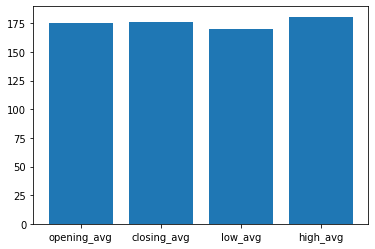

In [20]:

keys = aggpricing.keys()
values = aggpricing.values()
plt.bar(keys, values)
plt.title("All time Averages")

In [21]:
#works fine: find gte - lte date range - BUT Not through aggregation pipeline

resultwww = weekcol.find({
    "$and" : [{
                 "date" : { "$gt" :datetime.datetime(2020, 12, 30, 0, 0, tzinfo=pytz.utc)}
              },
              {
                   "date" : { "$lt" :datetime.datetime(2021, 1, 30, 0, 0, tzinfo=pytz.utc)}
              }]
})


for ttt in resultwww:
    print(ttt)

{'_id': ObjectId('5ff81ad1d02ecab08b899a21'), '1_open': 133.52, '2_high': 133.6116, '3_low': 126.382, '4_close': 130.92, '5_volume': 505632912.0, 'date': datetime.datetime(2021, 1, 7, 0, 0)}
{'_id': ObjectId('5ff81ad1d02ecab08b899a22'), '1_open': 133.99, '2_high': 138.789, '3_low': 131.72, '4_close': 132.69, '5_volume': 439740666.0, 'date': datetime.datetime(2020, 12, 31, 0, 0)}
{'_id': ObjectId('5ff976dab4562bd59df9596b'), '1_open': 133.52, '2_high': 133.6116, '3_low': 126.382, '4_close': 132.05, '5_volume': 610791157.0, 'date': datetime.datetime(2021, 1, 8, 0, 0)}


In [30]:
# GT and LT date - working fine!!!!!!!!!!!!!!!
betdate = weekcol.aggregate([
    ## stage 1
    {"$match":{
  
"date": {"$gt": datetime.datetime(2019, 12, 31, 0, 0, tzinfo=pytz.utc)}

}}
    ,
    
{"$match":{
  
"date": {"$lt": datetime.datetime(2021, 1, 1, 0, 0, tzinfo=pytz.utc)}

}}
    
])

for bdate in betdate:
    print(bdate)
    

    


{'_id': ObjectId('5ff81ad1d02ecab08b899a22'), '1_open': 133.99, '2_high': 138.789, '3_low': 131.72, '4_close': 132.69, '5_volume': 439740666.0, 'date': datetime.datetime(2020, 12, 31, 0, 0)}
{'_id': ObjectId('5ff81ad1d02ecab08b899a23'), '1_open': 125.02, '2_high': 134.405, '3_low': 123.449, '4_close': 131.97, '5_volume': 433757134.0, 'date': datetime.datetime(2020, 12, 24, 0, 0)}
{'_id': ObjectId('5ff81ad1d02ecab08b899a24'), '1_open': 122.6, '2_high': 129.58, '3_low': 121.54, '4_close': 126.655, '5_volume': 621758148.0, 'date': datetime.datetime(2020, 12, 18, 0, 0)}
{'_id': ObjectId('5ff81ad1d02ecab08b899a25'), '1_open': 122.31, '2_high': 125.95, '3_low': 120.15, '4_close': 122.41, '5_volume': 452278651.0, 'date': datetime.datetime(2020, 12, 11, 0, 0)}
{'_id': ObjectId('5ff81ad1d02ecab08b899a26'), '1_open': 116.97, '2_high': 123.78, '3_low': 116.81, '4_close': 122.25, '5_volume': 541563385.0, 'date': datetime.datetime(2020, 12, 4, 0, 0)}
{'_id': ObjectId('5ff81ad1d02ecab08b899a27'), '1

In [80]:
# GT and LT date - working fine!!!!!!!!!!!!!!!
betdate = weekcol.aggregate([
    ## stage 1
    {"$match":{
  
"date": {"$gt": datetime.datetime(2020, 11, 30, 0, 0, tzinfo=pytz.utc)}

}}
    ,
    
{"$match":{
  
"date": {"$lt": datetime.datetime(2020, 12, 31, 0, 0, tzinfo=pytz.utc)}

}},
    ## stage 2
    {
        "$group" : { "_id" : "jan",
                     "average_opening_price" : {
                         "$avg" : "$1_open"
                     },
                    "average_closing_price" : {
                        "$avg" : "$4_close"
                    }
        } 
    }
    
])

jandic = {}
for bdate in betdate:
   
    jandic["Title"] = bdate["_id"]
    jandic["Average_opening_price"] = bdate["average_opening_price"]
    jandic["Average_closing_price"] = bdate["average_closing_price"]
    

    


In [82]:
del jandic["Title"]

Text(0.5, 1.0, 'January')

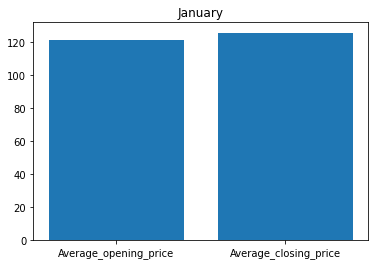

In [85]:
keys = jandic.keys()
values = jandic.values()
plt.bar(keys, values)
plt.title("January")